In [12]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [13]:
df = pd.read_csv("GE.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-09-10,49.360001,49.599998,48.000000,48.000000,47.805088,12165600
1,2020-09-11,48.320000,48.400002,47.439999,47.599998,47.406708,8989825
2,2020-09-14,47.919998,49.279999,47.680000,49.200001,49.000214,9250263
3,2020-09-15,49.360001,49.759998,48.160000,48.799999,48.601837,10793850
4,2020-09-16,48.799999,54.480000,48.400002,54.000000,53.780724,31998313


In [14]:
train_dates = pd.to_datetime(df['Date'])
train_dates.tail(10)

242   2021-08-26
243   2021-08-27
244   2021-08-30
245   2021-08-31
246   2021-09-01
247   2021-09-02
248   2021-09-03
249   2021-09-07
250   2021-09-08
251   2021-09-09
Name: Date, dtype: datetime64[ns]

In [15]:
cols =list(df)[1:6]
print(cols)

['Open', 'High', 'Low', 'Close', 'Adj Close']


In [16]:
df_for_training = df[cols].astype(float)

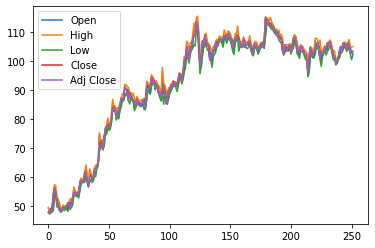

In [17]:
df_for_plot = df_for_training.tail(5000)
df_for_plot.plot.line()

In [18]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [19]:
trainX = []
trainY = []

In [20]:
n_future = 1
n_past = 14

In [21]:
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

In [22]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (238, 14, 5).
trainY shape == (238, 1).


In [23]:
model =Sequential()
model.add(LSTM(62,activation='relu',input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 62)            16864     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12160     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 29,057
Trainable params: 29,057
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(optimizer='adam', loss='mse')

In [26]:
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/5
14/14 [==============================] - 6s 105ms/step - loss: 0.5116 - val_loss: 0.0716
Epoch 2/5
14/14 [==============================] - 1s 75ms/step - loss: 0.0992 - val_loss: 0.0220
Epoch 3/5
14/14 [==============================] - 1s 70ms/step - loss: 0.0603 - val_loss: 0.0164
Epoch 4/5
14/14 [==============================] - 1s 73ms/step - loss: 0.0705 - val_loss: 0.0135
Epoch 5/5
14/14 [==============================] - 1s 74ms/step - loss: 0.0522 - val_loss: 0.0204


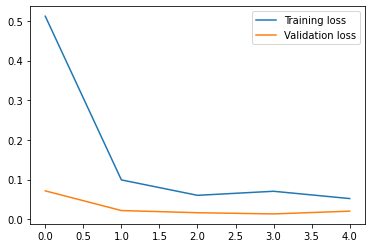

In [27]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [28]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

In [29]:
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [53]:
n_past = 16
n_days_for_prediction=90

In [54]:
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

[Timestamp('2021-08-18 00:00:00', freq='C'), Timestamp('2021-08-19 00:00:00', freq='C'), Timestamp('2021-08-20 00:00:00', freq='C'), Timestamp('2021-08-23 00:00:00', freq='C'), Timestamp('2021-08-24 00:00:00', freq='C'), Timestamp('2021-08-25 00:00:00', freq='C'), Timestamp('2021-08-26 00:00:00', freq='C'), Timestamp('2021-08-27 00:00:00', freq='C'), Timestamp('2021-08-30 00:00:00', freq='C'), Timestamp('2021-08-31 00:00:00', freq='C'), Timestamp('2021-09-01 00:00:00', freq='C'), Timestamp('2021-09-02 00:00:00', freq='C'), Timestamp('2021-09-03 00:00:00', freq='C'), Timestamp('2021-09-07 00:00:00', freq='C'), Timestamp('2021-09-08 00:00:00', freq='C'), Timestamp('2021-09-09 00:00:00', freq='C'), Timestamp('2021-09-10 00:00:00', freq='C'), Timestamp('2021-09-13 00:00:00', freq='C'), Timestamp('2021-09-14 00:00:00', freq='C'), Timestamp('2021-09-15 00:00:00', freq='C'), Timestamp('2021-09-16 00:00:00', freq='C'), Timestamp('2021-09-17 00:00:00', freq='C'), Timestamp('2021-09-20 00:00:00'

In [55]:
prediction = model.predict(trainX[-n_days_for_prediction:])

In [56]:
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [57]:
print(y_pred_future)

[104.58174  104.42428  104.25972  104.11672  104.019585 104.03604
 103.974754 103.75493  103.46853  103.2957   103.223114 103.15335
 103.05412  102.96116  102.919876 102.96028  103.005394 103.1114
 103.62286  104.314735 105.12436  105.92749  106.66229  107.24868
 107.696915 108.02919  108.17972  108.20503  108.12776  107.9769
 107.73775  107.44109  106.90725  106.14991  105.477806 104.88089
 104.33556  103.92043  103.62857  103.347626 103.15891  103.14861
 103.306656 103.508316 103.54641  103.428795 103.20551  103.10261
 102.99374  102.86257  102.67892  102.41836  102.09991  101.4684
 100.92844  100.70527  100.59998  100.54743  100.588806 100.8406
 101.16663  101.50065  101.74547  101.86491  101.85397  101.798386
 101.77202  101.87242  101.91106  101.99367  102.175224 102.42899
 102.64831  102.673256 102.52053  102.27313  101.88163  101.46838
 101.13143  100.94457  100.94531  101.01774  101.225784 101.49278
 101.74688  101.91256  102.11168  102.34075  102.46207  102.45972 ]


In [58]:
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [69]:
original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2021-5-1']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


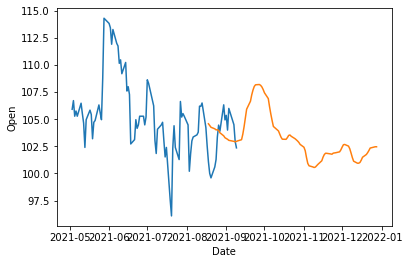

In [70]:
sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])